# Visual QC notebook

This notebook is designed to be used in a visual QC check of computed indicators. Indicator files are counted, and a percentage of the files (here 10%) are randomly selected for QC. Using only the output file names, we will:
- locate the original source data used to compute the indicators
- recompute the indicators
- compare the two datasets numerically (they should equal each other), visually (they should look the same when plotted), and contextually (known regions or features should make sense with regard to shape/size, location of coastlines, reasonable indicator values, etc).

#### How to use with `prefect` via `papermill`: 

This notebook should be run as the final step of the `prefect` indicator flow. The output will be saved as a new notebook in the QC directory created during the flow. To accomplish this, create a task in the `prefect` flow that will execute this notebook from the command line using `papermill`, e.g.:

```papermill path/to/repo/indicators/visual_qc.ipynb path/to/qc/output/output.ipynb -r working_directory "/path/to/working/dir" -r input_directory "/path/to/input/dir"```


 The first argument is this notebook's location, which can be constructed using the `{working_directory}` parameter of the flow run (ie, the notebook's location within the downloaded repo directory). The second argument is the desired notebook output location, which can also be constructed using the `{working_directory}` parameter of the flow run. The remaining arguments are raw strings (denoted by `-r`) of the working and input directories used in the flow run.

Papermill parameter cell:

In [1]:
# this cell is tagged "parameters" and contains default parameter values for this notebook
# any parameters injected by papermill during the prefect flow will be written into a new cell directly beneath this one
# and will override the values in this cell
working_directory = "/import/beegfs/CMIP6/snapdata/"
input_directory = "/import/beegfs/CMIP6/arctic-cmip6/regrid/"
historical_directory = "/import/beegfs/CMIP6/arctic-cmip6/daymet/"

Import packages.

In [2]:
from pathlib import Path
import random
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from indicators import *
from luts import idx_varid_lu, varid_freqs

# silence warnings during plotting
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# if you want to run this notebook interactively, outside of the prefect flow, you will have to grab the functions directly from the repo location
# which is in a higher directory than this notebook
# revise the code below to point to the location of the cmip6-indicators repo on your system and add it to the sys.path list

# import sys
# sys.path.append("/import/beegfs/CMIP6/jdpaul3/cmip6_indicators/cmip6-utils/indicators")
# from indicators import *
# from luts import idx_varid_lu, varid_freqs

#### Setup
Define data sources and parameters for QC.

In [ ]:
# convert dirs to Path objects
input_dir = Path(input_directory)
hist_dir = Path(historical_directory)
output_dir = Path(working_directory).joinpath("cmip6_indicators/")

# set fp to world coastlines shp for plotting reference
shp_fp = Path(working_directory).joinpath(
    "cmip6-utils/indicators/shp/ne_110m_coastline.shp"
)
# can also use local path to shp if running nb outside of prefect flow:
# shp_fp = Path('/home/jdpaul3/cmip6-utils/indicators/shp/ne_110m_coastline.shp')

# load world coastline shp to geodataframe
coastlines = gpd.read_file(shp_fp)

# list all netCDF files in the output directory
output_files = [f for f in output_dir.glob("**/*.nc")]

# set min and max number of files to QC
min_qc = 20
max_qc = 75

# pick a percentage of the output files for visual QC, and count those files
pct = 10
pct_count = round(len(output_files) * (pct / 100))

# use all files if less than minimum are available
# use max number of random files if percentage exceeds maximum
# or just use percentage of random files
if len(output_files) <= min_qc:
    qc_files = output_files
elif pct_count >= max_qc:
    qc_files = random.sample(output_files, max_qc)
else:
    qc_files = random.sample(output_files, pct_count)

# lat/lon slices and titles for these regions
# lat slices in this dataset have been reversed for Rasdaman, so we need to reverse them here too
lat_slices = [slice(80, 65), slice(75, 55), slice(80, 60)]
lon_slices = [slice(45, 70), slice(-179, -160), slice(-50, -20)]
region_titles = ["Barents/Kara Seas", "Bering/Chukchi Seas", "Greenland"]

Create a function that will deconstruct the file path of a computed indicator, and use its parts to locate the source files used to compute that indicator. The indicator is recomputed, all years are merged, and output is an `xarray.Dataset` that should be an exact match of the original indicator file. **Note that this will grab all regridded source files for each variable!**

In [6]:
def find_inputs_and_recompute_indicator(fp, input_dir):
    source_files = {}
    indicator, model, scenario = (
        fp.parts[-1].split("_")[0],
        fp.parts[-1].split("_")[1],
        fp.parts[-1].split("_")[2],
    )
    vars = idx_varid_lu[indicator]
    for var in vars:
        frequency = varid_freqs[var][0]
        source_files[var] = [
            f
            for f in input_dir.joinpath(model, scenario, frequency, var).glob("**/*.nc")
        ]

    coord_labels = dict(scenario=scenario, model=model)
    ds = xr.merge(
        run_compute_indicators(source_files, [indicator], coord_labels, hist_dir)
    )

    return ds

Create a function to test if two `xarray.Dataset`s are equal, and return a message.

In [7]:
def are_they_equal(fp, ds1, ds2):
    if ds1.equals(ds2):
        print(f"PASS: Recomputed indicator data from {fp} is identical to original.")
        return True
    else:
        print(f"FAIL: Recomputed indicator data from {fp} does not match to original.")
        return False

Create a function that will slice the recomputed indicator dataset by lat/lon, and plot a random year. Add descriptive titles/subtitles. 

In [ ]:
def slice_and_plot(fp, ds1, ds2):
    # get the data variable (ie, the indicator)
    var = [i for i in ds1.data_vars][0]
    # get a random year
    y = random.sample(ds1.year.values.tolist(), 1)[0]
    # create figure and subplots
    fig, axes = plt.subplots(3, 2, figsize=(13, 11))
    # repeat datasets and subtitles in the correct order for zipping with subplot axes
    rpt_ds = [ele for ele in [ds1, ds2] for i in range(3)]
    rpt_subtitles = [ele for ele in ["Original", "Recomputed"] for i in range(3)]

    # loop thru zipped subplot axes and plot parameters
    for ax, lat_slice, lon_slice, ds, title, subtitle in zip(
        axes.T.flat,
        lat_slices * 2,
        lon_slices * 2,
        rpt_ds,
        region_titles * 2,
        rpt_subtitles,
    ):
        # slice the data for the lat/lon region and plot
        # dims must be transposed to lat/lon order for geographical plotting
        ds[var].sel(year=y, lat=lat_slice, lon=lon_slice).transpose(
            "scenario", "model", "lat", "lon"
        ).plot(ax=ax, vmin=0, add_labels=False)
        coastlines.plot(color="red", ax=ax)
        ax.set_title(f"{title}: {subtitle}", fontsize=14)

    fp_str = str(fp)
    fig.suptitle(
        f"File: {fp_str} \n Year: {y} \n Indicator: {var} \n Units: {ds1[var].attrs['units']}"
    )

    plt.show()

    return None

#### Run the recomputation, assess equality, & plot

PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/HadGEM3-GC31-LL/historical/rx1day/rx1day_HadGEM3-GC31-LL_historical_indicator.nc is identical to original.
PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/MPI-ESM1-2-LR/ssp126/rx1day/rx1day_MPI-ESM1-2-LR_ssp126_indicator.nc is identical to original.
PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/CNRM-CM6-1-HR/historical/su/su_CNRM-CM6-1-HR_historical_indicator.nc is identical to original.
PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/HadGEM3-GC31-MM/ssp126/dw/dw_HadGEM3-GC31-MM_ssp126_indicator.nc is identical to original.
PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/KACE-1-0-G/historical/dw/dw_KACE-1-0-G_historical_indicator.nc is identical to original.
PASS: Recomputed indicator data from /import/beegfs/CMIP6/snapdata/output/EC-Earth3-Veg/ssp126/ftc/ftc_EC-Earth3-Veg_ssp126_indicator.nc is identical to 

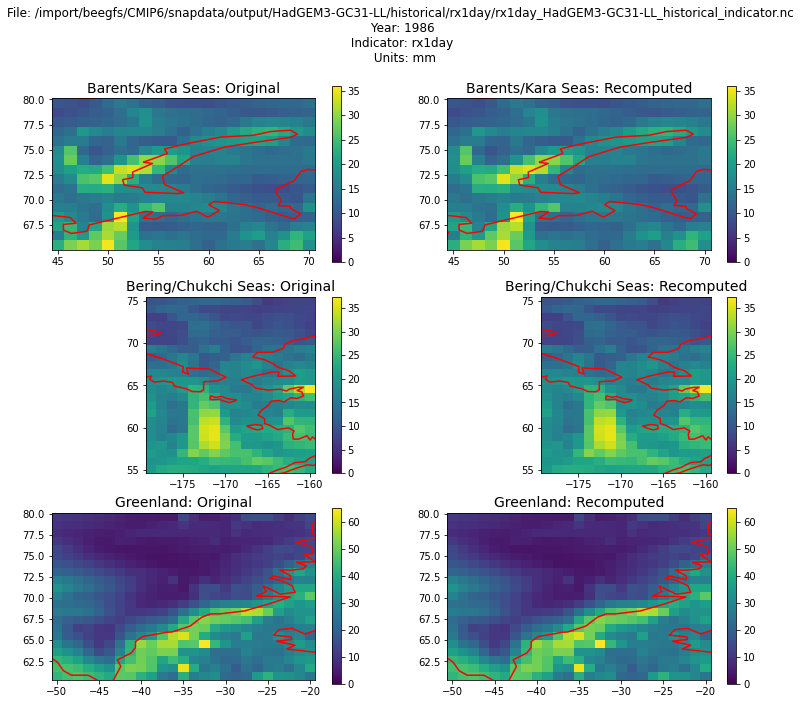

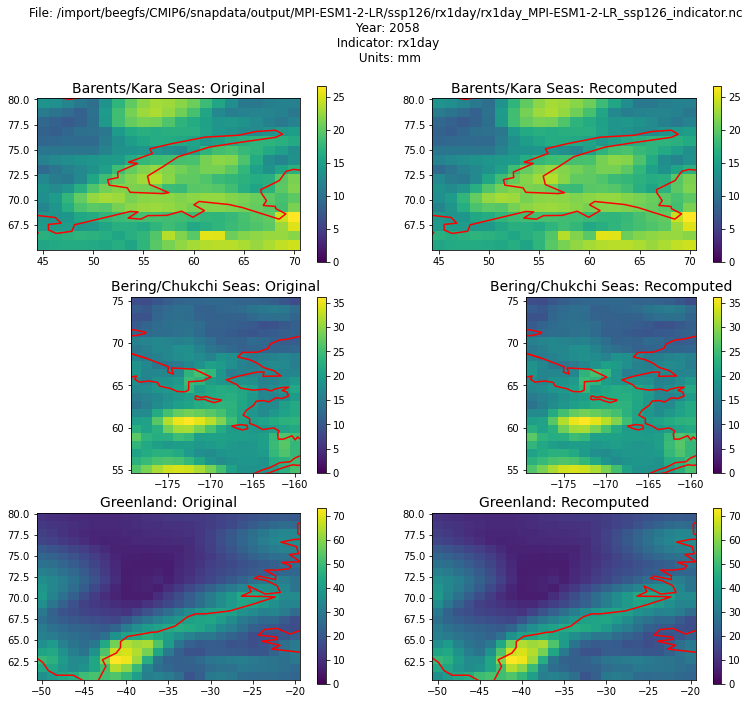

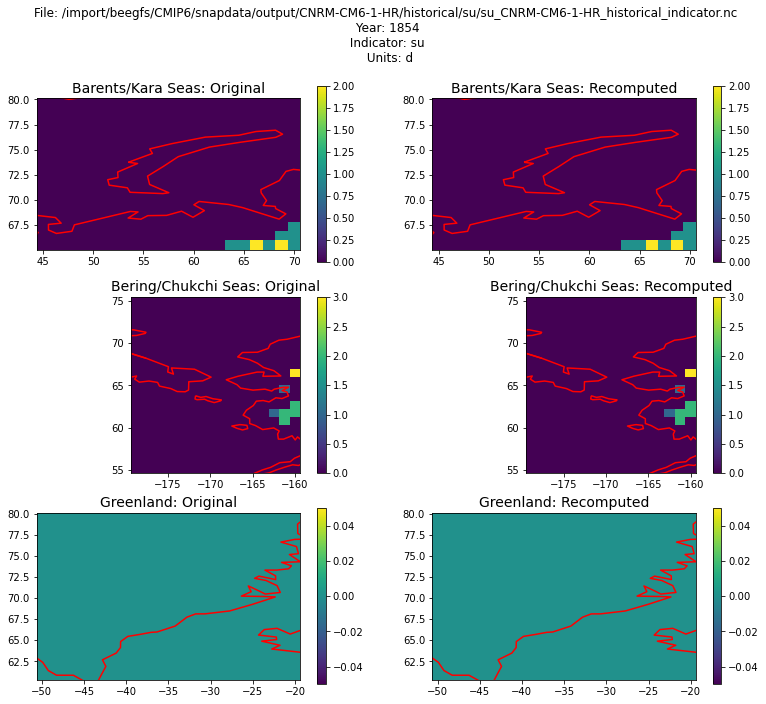

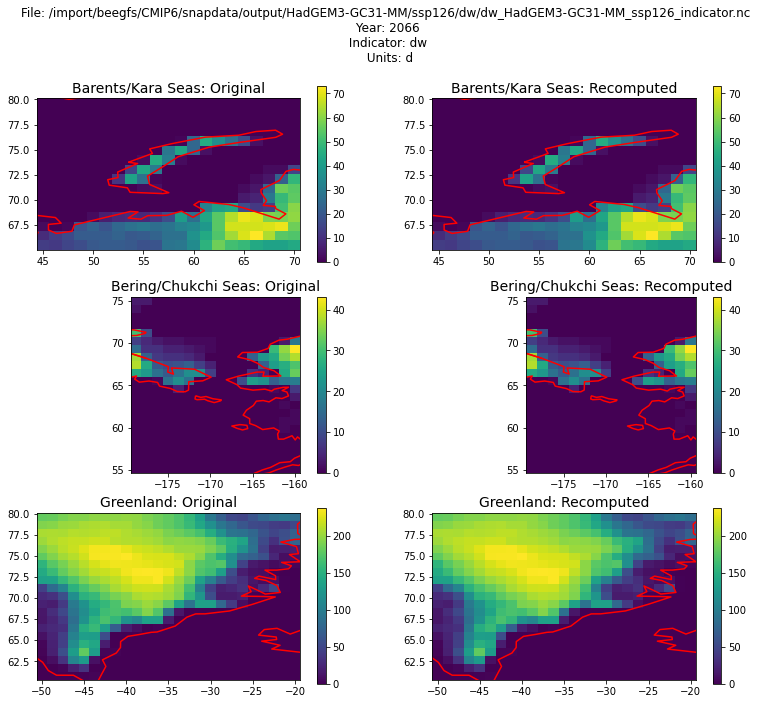

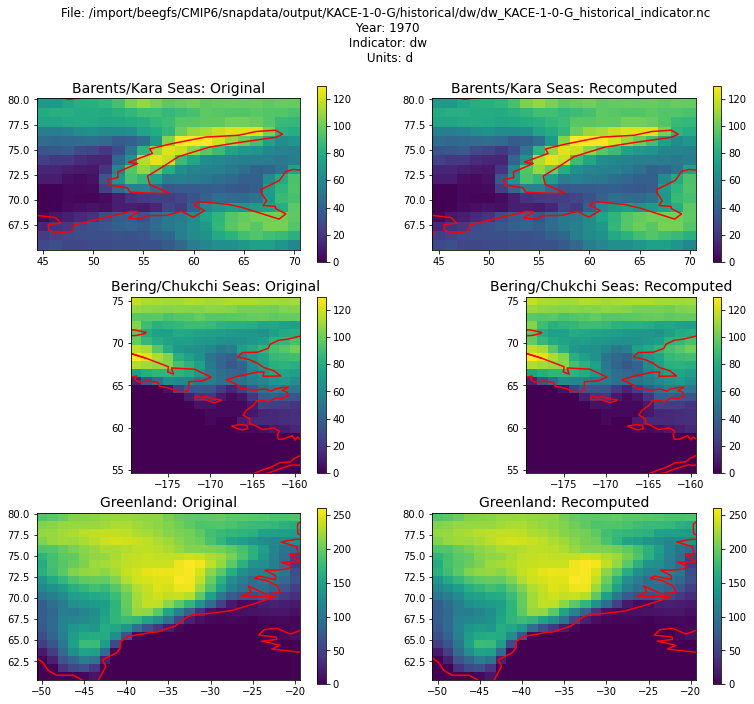

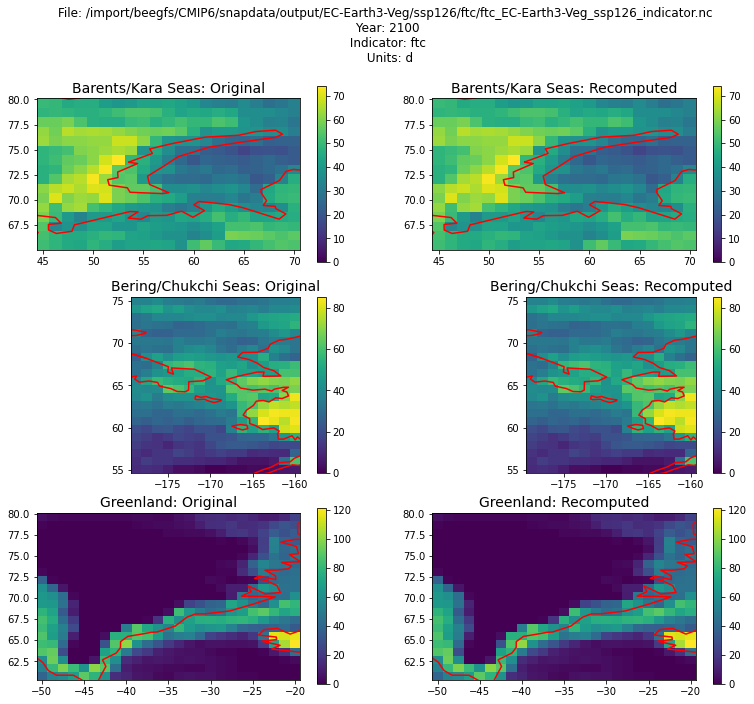

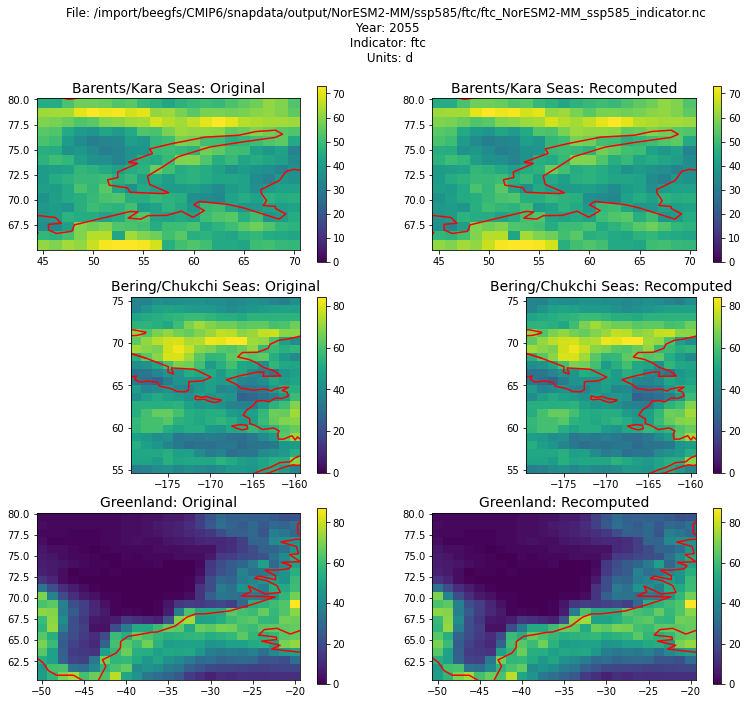

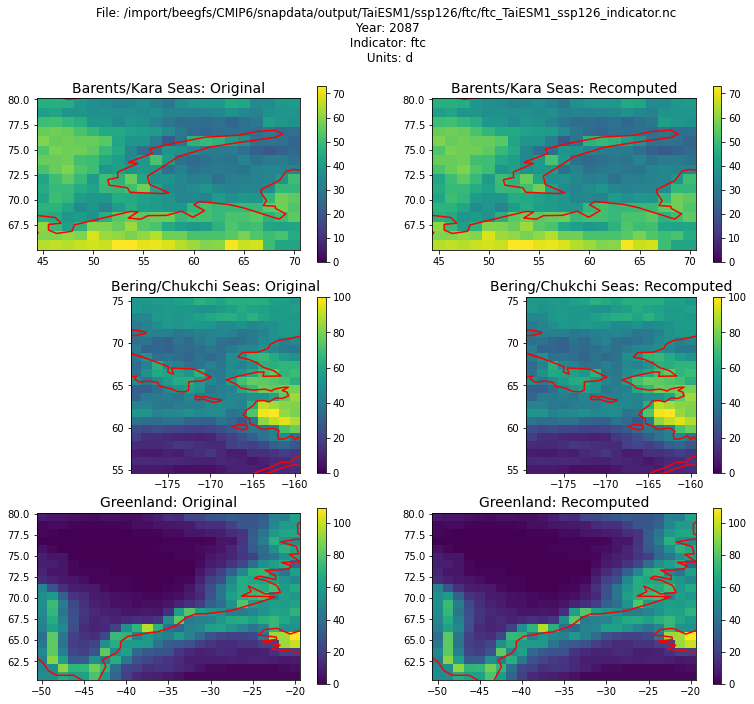

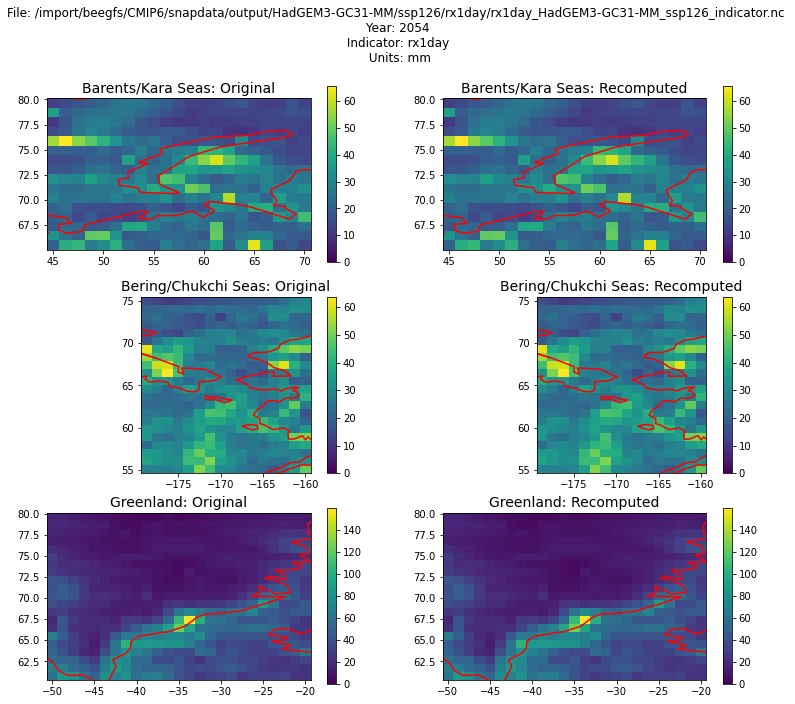

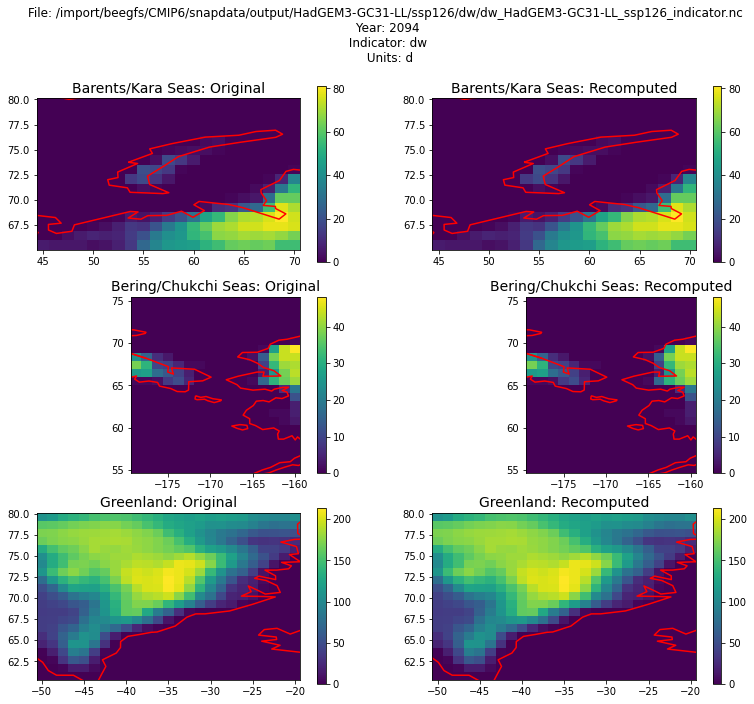

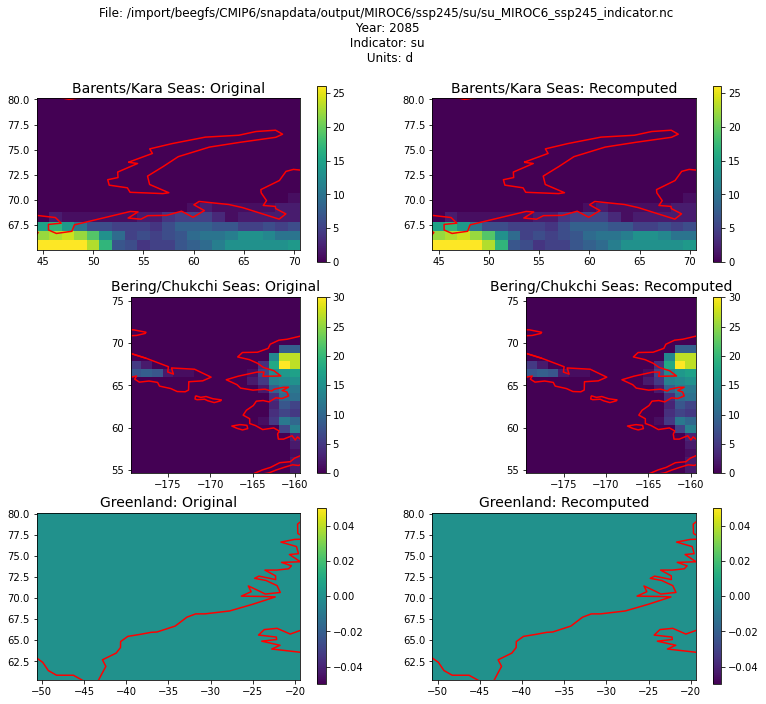

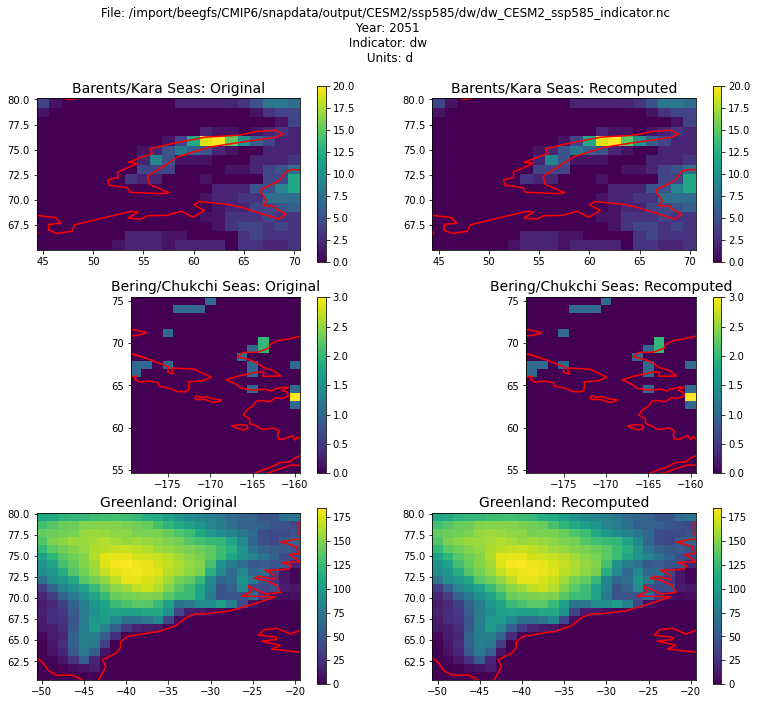

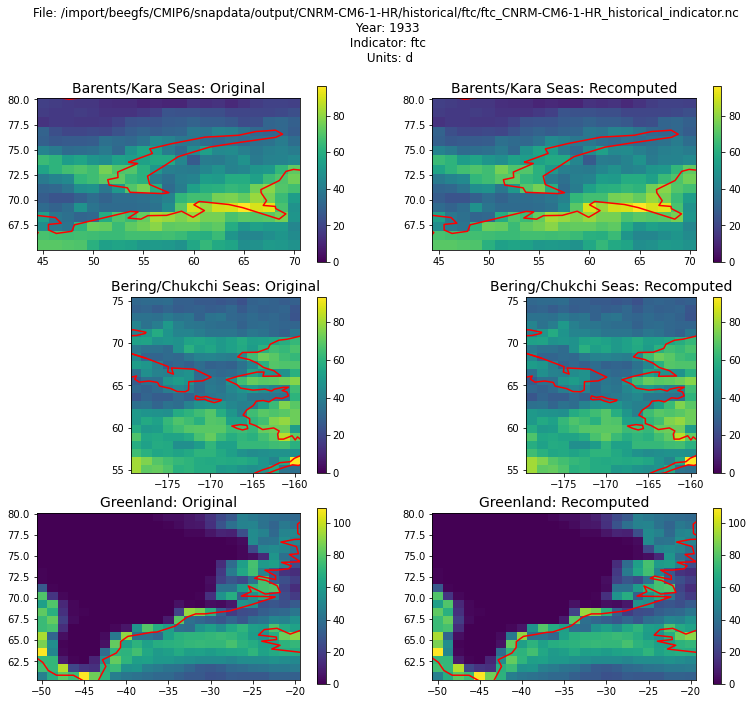

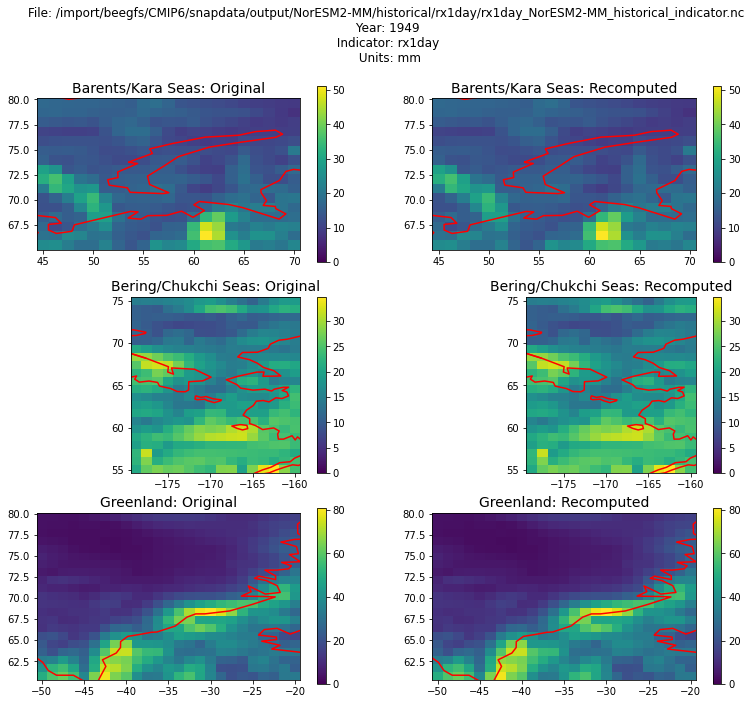

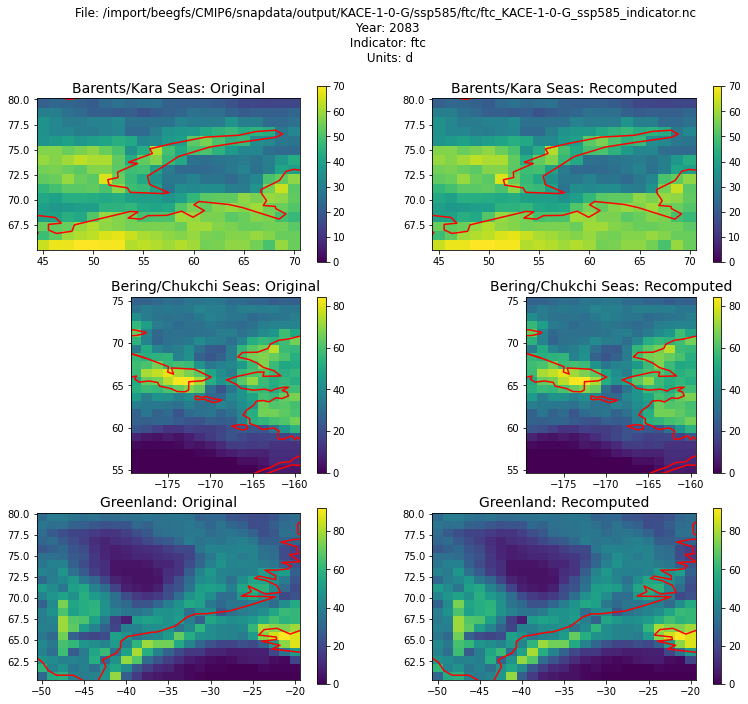

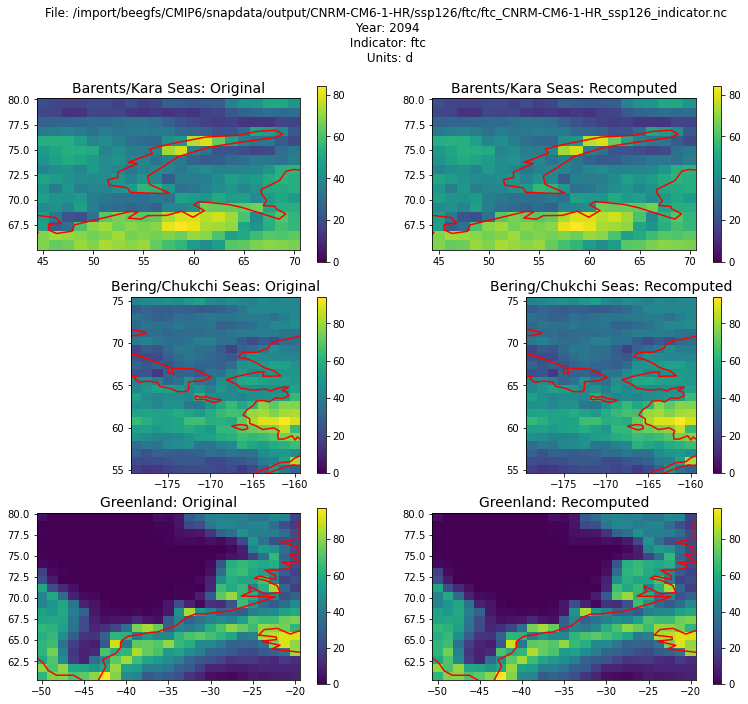

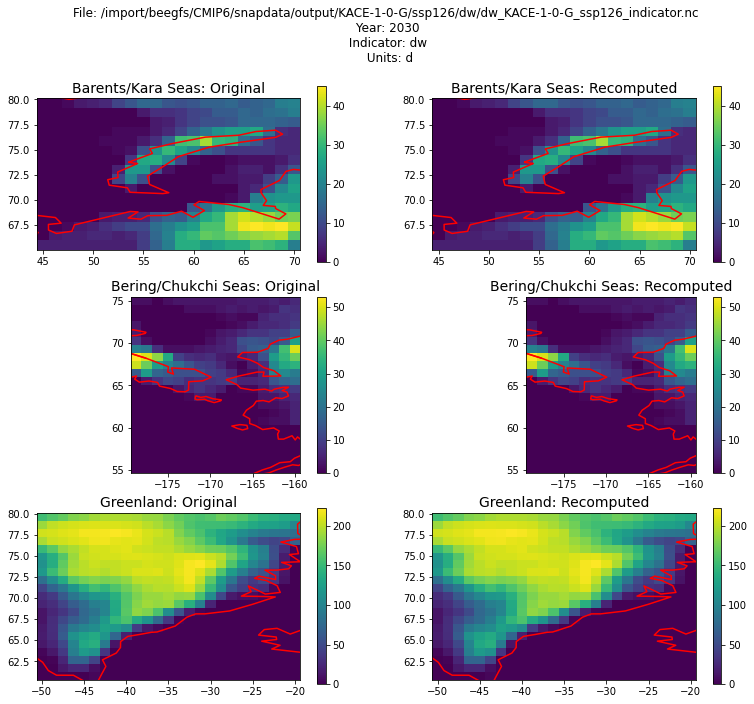

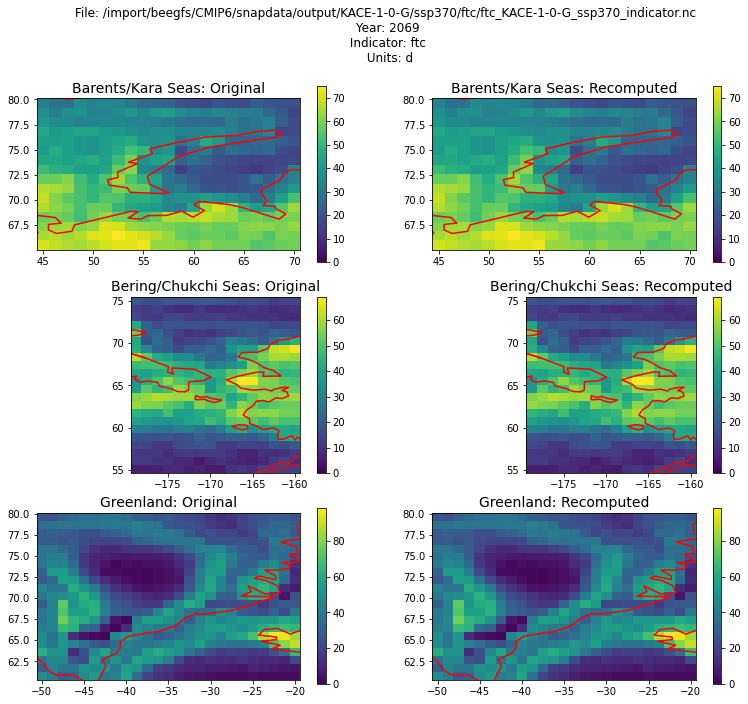

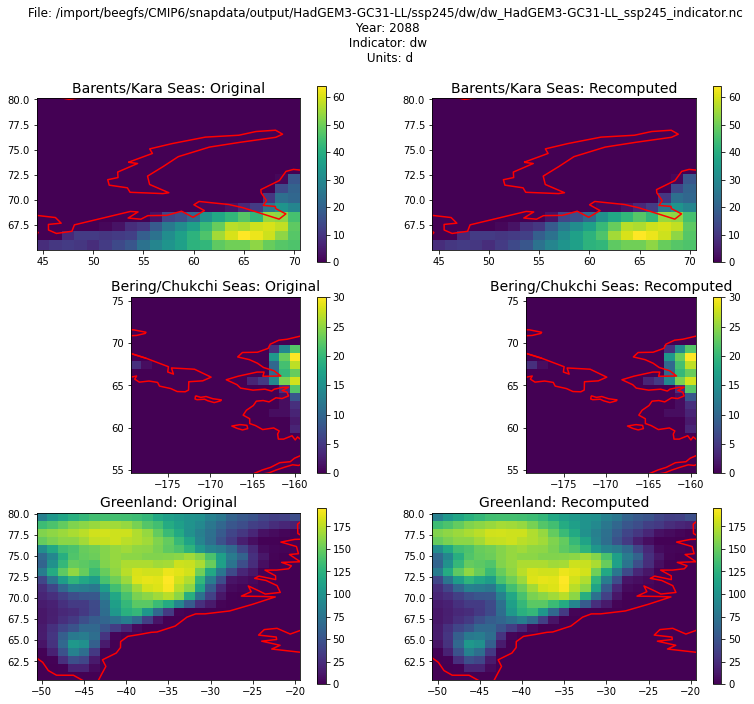

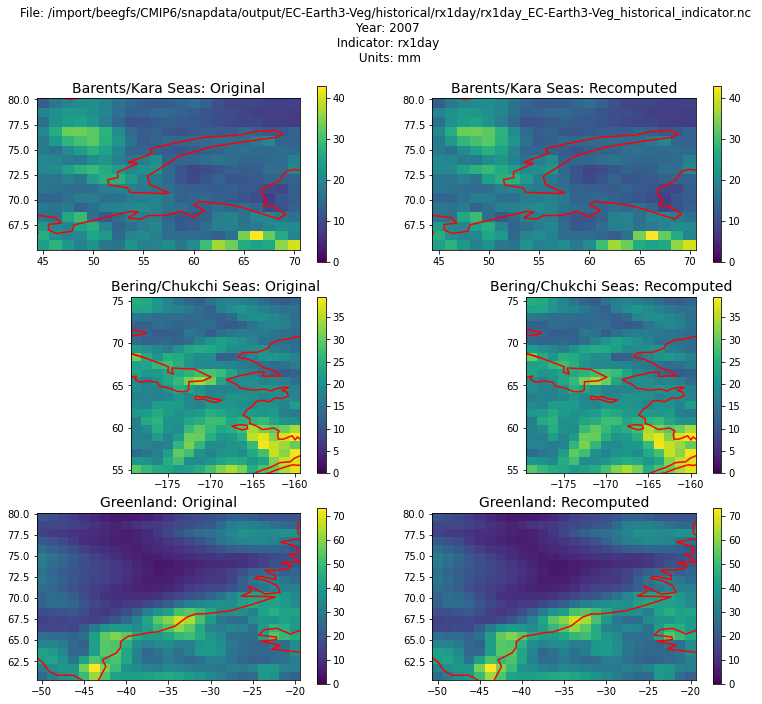

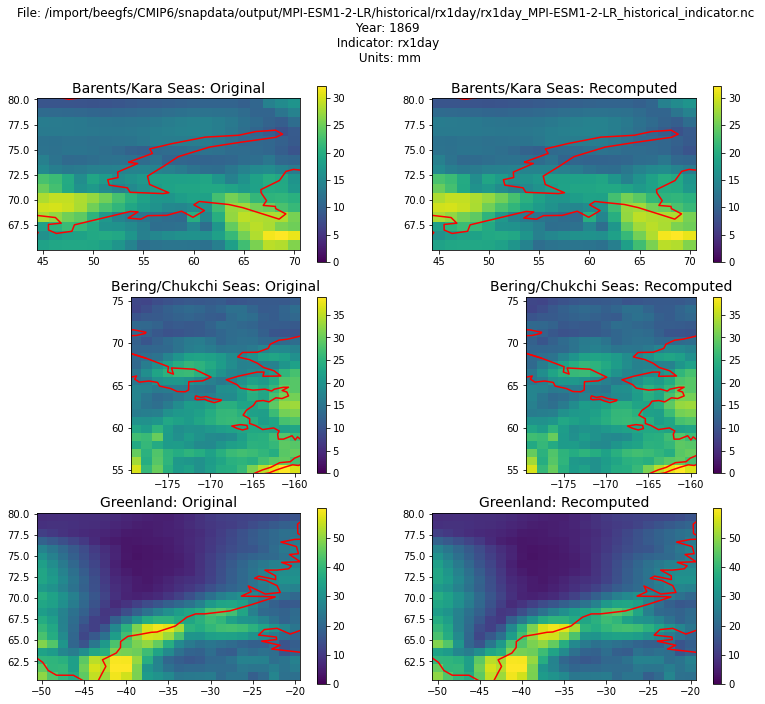

In [ ]:
original_datasets = []
recomputed_datasets = []

for f in qc_files:
    recomputed_ds = find_inputs_and_recompute_indicator(f, input_dir)
    recomputed_datasets.append(recomputed_ds)
    original_ds = xr.open_dataset(f)
    original_datasets.append(original_ds)

    # drop height variable if it exists - this is done outside of the compute indicator functions
    # and so we need to drop it here before comparing
    if "height" in list(recomputed_ds.variables):
        recomputed_ds = recomputed_ds.drop_vars("height")

    are_they_equal(f, original_ds, recomputed_ds)

In [ ]:
for f, o, r in zip(qc_files, original_datasets, recomputed_datasets):
    slice_and_plot(f, o, r)